# **Rain**
Correlations between the **total precipitation** *(tp)* and the mean amplitude for different frequencies

Initialisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [2]:
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src") # Path of the root directory
catalog_path = "/media/imonge/CORSAIR" # Path of the hard disk containing the MAHY data

stations = StationsCatalog(catalog_path)
# %matplotlib qt #-> Use this in case you want to have the plot in a new window

In [3]:
# Take the time dates from the MAHY csv
cat_info = pd.read_csv(catalog_path + '/MAHY/MAHY.csv', parse_dates=['date_start', 'date_end'])
cat_info.set_index('station_name', inplace=True)
cat_info["date_start"] = pd.to_datetime(cat_info["date_start"])
cat_info["date_end"] = pd.to_datetime(cat_info["date_end"])

# Determine the first date and last date of all MAHY campaigns to match with the current speed dates
date_start_total = cat_info["date_start"].min()
date_end_total = cat_info["date_end"].max()

Save rain data in a numpy file

In [4]:
output_path_rain = "/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_soundscape/rain"

for station in stations:

    hydro_number = station.name[-1]
    station_code = f"h{hydro_number}"

    date_start = station.date_start
    date_end = station.date_end

    rain_path = f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/ERA5_concat/ERA5_MAHY*{hydro_number}_rain_merged.nc"
    rain_data = xr.open_dataset(rain_path)

    t = pd.to_datetime(rain_data["valid_time"].values)

    mask = (t>date_start) & (t<date_end)

    total_precipitation = np.array(rain_data["tp"]).flatten()

    np.save(os.path.join(output_path_rain, f"total_precipitation_" + station_code + ".npy"), total_precipitation)

Choose the stations

In [4]:
# Select the stations you want to plot. /!\ You can only choose stations for one hydrophone
selected_stations = ["MAHY02",
                     "MAHY12",
                     "MAHY22",
                     "MAHY32",
                     "MAHY42"
                     ]

hydrophone_number = [station[-1] for station in selected_stations]
# Check that only one hydrophone is chosen
if len(set(hydrophone_number))>1:
    raise ValueError("You have selected more than one hydrophone")
else:
    print(f"Hydrophone n°{hydrophone_number[0]} selected")

Hydrophone n°2 selected


Spectrogram with total precipitation overlaid for the stations selected

/tmp/ipykernel_47323/507597421.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Daily precipitation (cm/day) overlaid on the spectrogram')

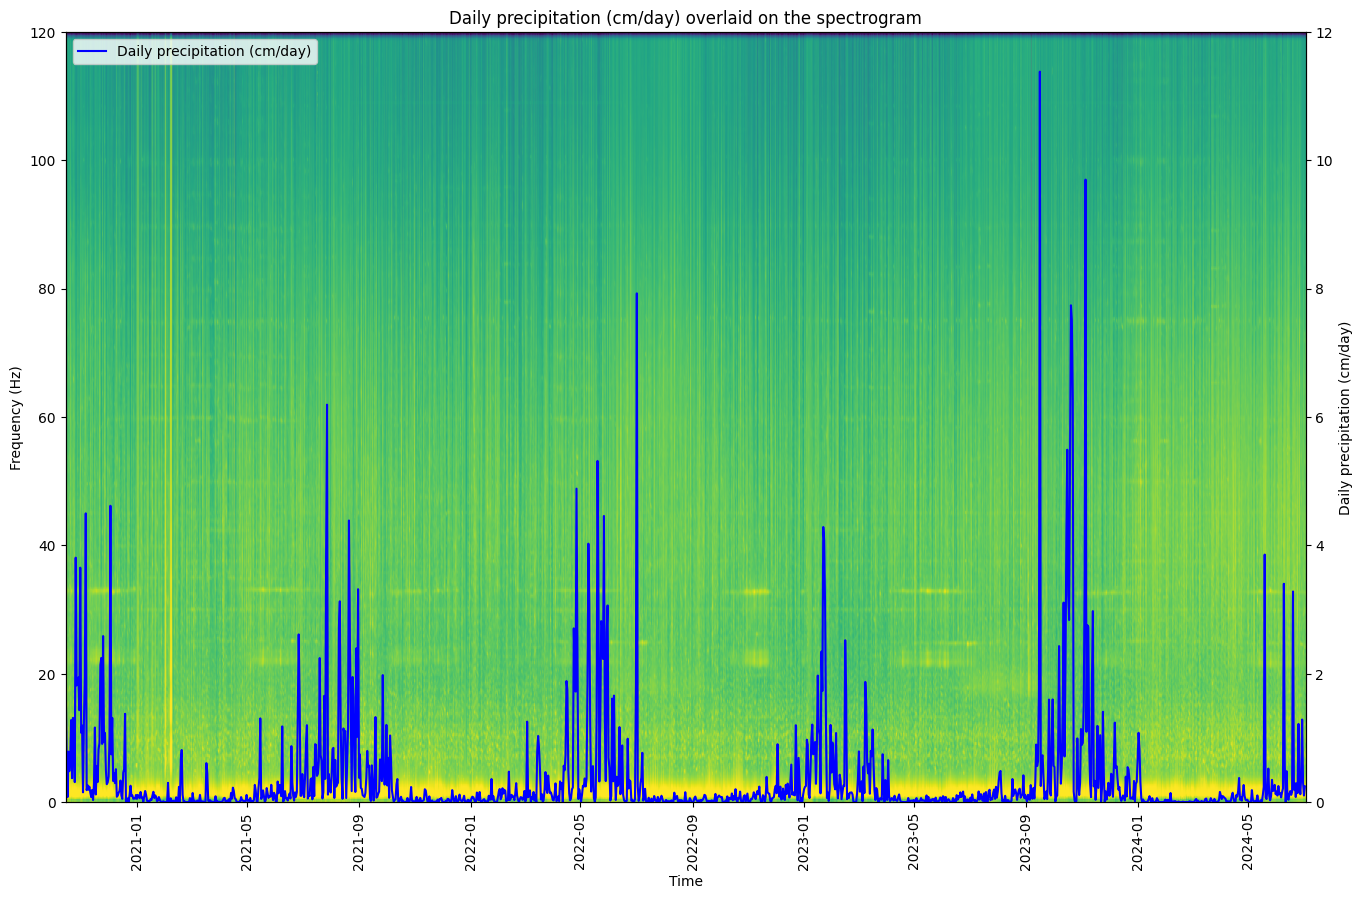

In [5]:
# Path of the directories containing psds and total precipitation data
mahy_path = "/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_mahy"
rain_path = f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_soundscape/rain/total_precipitation_h{hydrophone_number[0]}.npy"

# Take the dates from de MAHY csv
date_start = cat_info["date_start"].loc[selected_stations[0]]
date_end = cat_info["date_end"].loc[selected_stations[-1]]

# Spectrogram
psds_all = []

for station in selected_stations:
    psd_path = os.path.join(mahy_path, f"PSDS_{station}.npy")
    psds = np.load(psd_path)
    psds_all.append(psds)

# Concatenate psds
final_psd = np.vstack(psds_all)

# Total precipitation
total_precipitation = np.load(rain_path)

dates_all = pd.date_range(start=date_start, end=date_end, periods=len(total_precipitation))
assert len(total_precipitation) == len(dates_all); "Mismatch in toral_precipitation and dates_all length"

# # Gather the total precipitation per day
# df_rain = pd.DataFrame({
#     "date": dates_all,
#     "precip": total_precipitation
# })
# df_rain["date_day"] = df_rain["date"].dt.floor("D")
# daily_precipitation = df_rain.groupby("date_day")["precip"].sum()
# daily_dates = daily_precipitation.index

# Gather the total precipitation per week
df_rain = pd.DataFrame({
    "date": dates_all,
    "precip": total_precipitation
})
df_rain["date_day"] = df_rain["date"].dt.floor("D")
daily_precipitation = df_rain.groupby("date_day")["precip"].sum()
daily_precipitation_cm = daily_precipitation * 100
daily_dates = daily_precipitation_cm.index

# # Interpolate total precipitation in order to correspond to the spectrogram dates
# if len(dates_all) != len(total_precipitation):
#     total_precipitation_interp = np.interp(pd.to_numeric(dates_all), pd.to_numeric(dates_all), total_precipitation)
#
# else:
#     total_precipitation_interp = total_precipitation

# Create plot and axis
fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for daily precipitation

sp = ax.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)

# Trace daily precipitation on the second axis
ax1.plot(daily_precipitation_cm.index, daily_precipitation_cm.values,label="Daily precipitation (cm/day)", color="blue")
ax1.set_ylim(0,12) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

# Add labels
ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Daily precipitation (cm/day)")
ax1.legend(loc="upper left")
ax.set_title("Daily precipitation (cm/day) overlaid on the spectrogram")

Correlations between the median amplitude and the total precipitation as a function of frequency

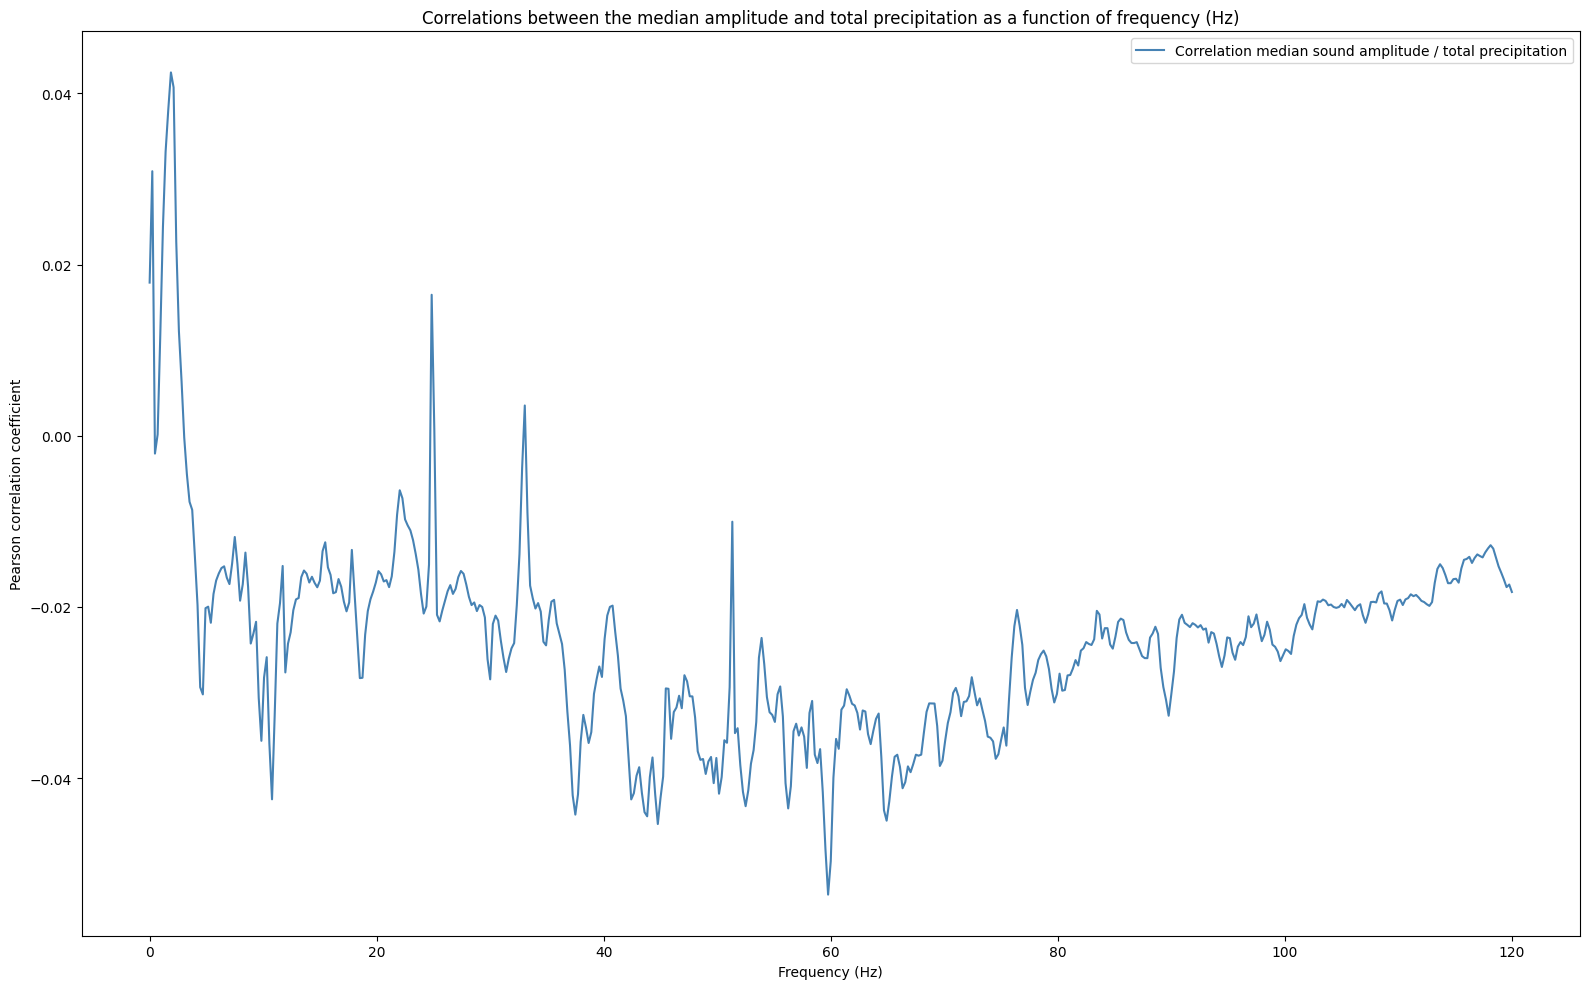

In [6]:
# Define the amplitude correlations
amplitude_corr = []

# Calculate the correlation between the filtered amplitude and the interpolated wind
for i in range(final_psd.shape[1]):
    amplitude = final_psd[:, i]
    amplitude_filt = medfilt(amplitude, kernel_size=51)

    amplitude_steps = amplitude_filt.shape[0]
    t_amplitude = pd.date_range(
        start=date_start,
        end=date_end,
        periods=amplitude_steps)

    #interpolated_rain interp1d(pd.to_numeric(dates_all), total_precipitation, bounds_error=False)(pd.to_numeric(t_amplitude))
    interpolated_rain = np.interp(pd.to_numeric(t_amplitude), pd.to_numeric(dates_all), total_precipitation)
    validmask = (~np.isnan(interpolated_rain)) & (~np.isnan(amplitude_filt) & (amplitude_filt != 0)) # remove nan values and null values

    if np.sum(validmask) > 0:
        corr_matrix = np.corrcoef(interpolated_rain[validmask], amplitude_filt[validmask])
        amplitude_corr.append(corr_matrix[0, 1])
    else:
        amplitude_corr.append(np.nan)

# Calculate the associated frequencies
fs = 240
nperseg = 1024
frequencies = np.fft.rfftfreq(nperseg, d=1 / fs)

# Create plot
plt.figure(figsize=(16,10))
plt.plot(frequencies, amplitude_corr, color="steelblue", label="Correlation median sound amplitude / total precipitation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Pearson correlation coefficient")
plt.title("Correlations between the median amplitude and total precipitation as a function of frequency (Hz)")
plt.legend()
plt.tight_layout()
plt.show()